# Homework Assignment 10

#### Preqrequests

In [1]:
!pip install -q pyspark findspark

### Imports

In [61]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from pyspark.ml import Pipeline
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub

##### Constant Values

In [11]:
SAMPLE_DATAPOINTS_VIZULIZATION: int = 20

### Download Datasets

In [6]:
wine_path = kagglehub.dataset_download("zynicide/wine-reviews")
carlisting_path = kagglehub.dataset_download("jpayne/852k-used-car-listings")
print("Wine dataset files:", wine_path)
print("Car listing dataset files:", carlisting_path)

Wine dataset files: /kaggle/input/wine-reviews
Car listing dataset files: /kaggle/input/852k-used-car-listings


**Question 1:** Use PySpark and the [Wine Reviews dataset](https://www.kaggle.com/zynicide/wine-reviews) to:
- Explore  the datasets using Spark DataFrame by creating **3 different data visualizations, including map visualization** (30pt)
- Create a regression model that can predict the Wine Review's points value and evaluate the model(20pt)

### Plotting

In [ ]:
spark = SparkSession.builder.appName("WineReviews").getOrCreate()
df = (
    spark.read.format("csv")
    .option("header", "true")
    .load(f"{wine_path}/winemag-data-130k-v2.csv")
)
df = df.withColumn("price", col("price").cast("double"))
df = df.withColumn("points", col("points").cast("double"))
df.summary()

DataFrame[summary: string, _c0: string, country: string, description: string, designation: string, points: string, price: string, province: string, region_1: string, region_2: string, taster_name: string, taster_twitter_handle: string, title: string, variety: string, winery: string]

In [ ]:
avrage_by_country = (
    df.groupby("country")
    .avg("price")
    .orderBy("avg(price)", ascending=False)
    .toPandas()
    .dropna()
    .head(SAMPLE_DATAPOINTS_VIZULIZATION)
)
avrage_country_points = (
    df.groupBy("country")
    .avg("points")
    .orderBy("avg(points)", ascending=False)
    .toPandas()
    .dropna()
    .head(SAMPLE_DATAPOINTS_VIZULIZATION)
)
count_active_tasters = (
    df.groupby("taster_name")
    .count()
    .orderBy("count", ascending=False)
    .toPandas()
    .dropna()
    .head(SAMPLE_DATAPOINTS_VIZULIZATION)
)

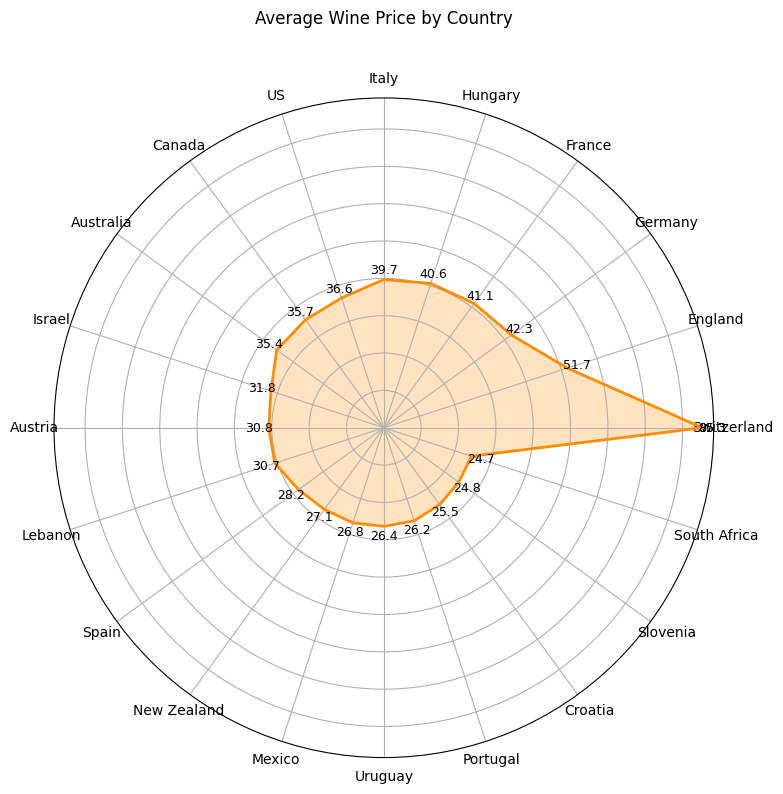

In [ ]:
categories = list(avrage_by_country["country"])
values = list(avrage_by_country["avg(price)"])
values += values[:1]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, values, color="darkorange", linewidth=2)
ax.fill(angles, values, color="darkorange", alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Average Wine Price by Country", y=1.1)
ax.set_yticklabels([])

for angle, value, label in zip(angles, values, values):
    ax.text(
        angle,
        value + max(values) * 0.03,
        f"{value:.1f}",
        ha="center",
        va="center",
        fontsize=9,
        color="black",
    )

plt.tight_layout()
plt.show()

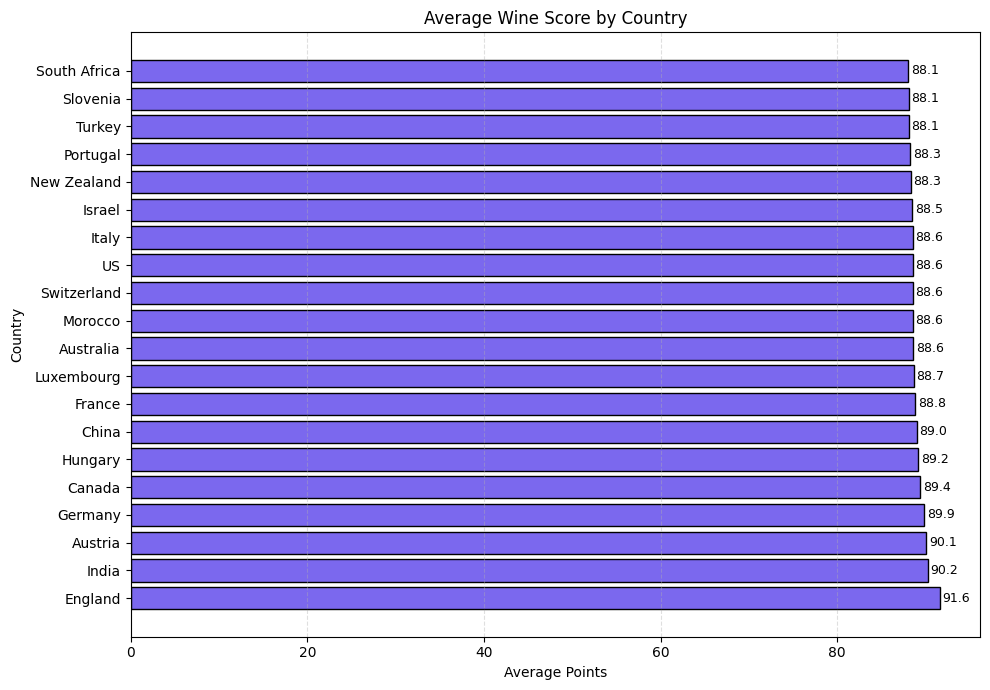

In [ ]:
plt.figure(figsize=(10, 7))
bars = plt.barh(
    avrage_country_points["country"],
    avrage_country_points["avg(points)"],
    color="mediumslateblue",
    edgecolor="black",
)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.3,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}",
        va="center",
        fontsize=9,
    )

plt.title("Average Wine Score by Country")
plt.xlabel("Average Points")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
fig = px.choropleth(
    avrage_by_country,
    locations="country",
    locationmode="country names",
    color="avg(price)",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Average Wine Price by Country",
)
fig.show()

#### ML Model

In [ ]:
selected_columns = ["points", "price", "country", "variety", "region_1"]
df_filtered = df.select(*selected_columns).dropna()

categorical_cols = ["country", "variety", "region_1"]
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(df_filtered)
    for col in categorical_cols
]
indexing_pipeline = Pipeline(stages=indexers)
indexed_df = indexing_pipeline.fit(df_filtered).transform(df_filtered)

feature_cols = ["price", "country_index", "variety_index", "region_1_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(indexed_df)

train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="points")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(
    labelCol="points", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

print(f"Test RMSE:\t{rmse:.2f}")

Test RMSE:	2.85


**Question 2:** Use PySpark and the [Used Car Listings dataset](https://www.kaggle.com/jpayne/852k-used-car-listings) to:
- Explore  the datasets using Spamrk DataFrame by creating **3 different data visualizations, including  map visualization** (30pt)
- Create a regression model that can predict a car's listing price and evaluate the model (20pt)



In [ ]:
def preprocess(row: pd.DataFrame) -> pd.DataFrame:
    row["State"] = row["State"].upper().replace(" ", "")
    return row

In [ ]:
spark = SparkSession.builder.appName("UsedCarsListings").getOrCreate()
carlisting = (
    spark.read.format("csv")
    .option("header", "true")
    .load(f"{carlisting_path}/true_car_listings.csv")
)

In [ ]:
carlisting_count = (
    carlisting.groupby("Make").count().orderBy("count").toPandas().dropna().head(20)
)
count_by_state = carlisting.groupby("State").count().orderBy("count").toPandas()
count_by_state = count_by_state.apply(preprocess, axis=1)

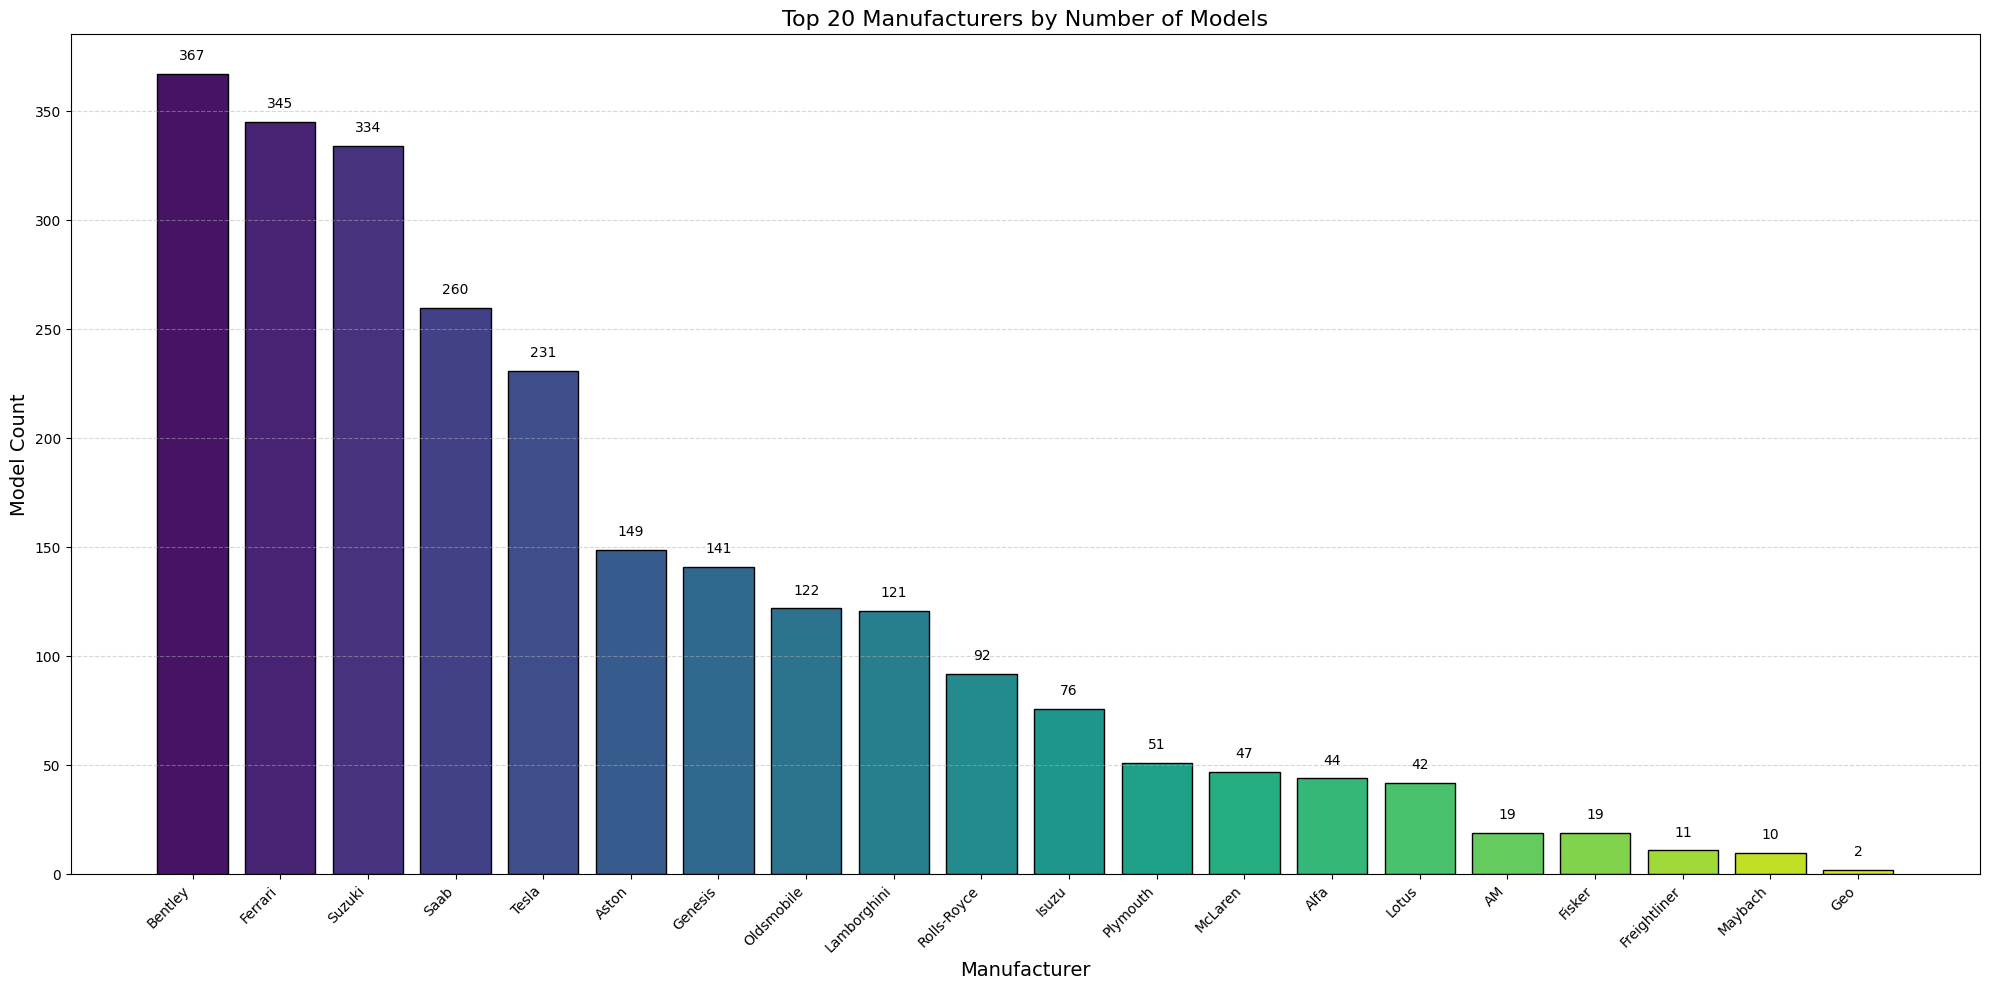

In [ ]:
carlisting_sorted = carlisting_count.sort_values("count", ascending=False)

sns.set_palette("pastel")
plt.figure(figsize=(20, 10))

bars = plt.bar(
    carlisting_sorted["Make"],
    carlisting_sorted["count"],
    color=sns.color_palette("viridis", n_colors=20),
    edgecolor="black",
)

plt.title("Top 20 Manufacturers by Number of Models", fontsize=16)
plt.xlabel("Manufacturer", fontsize=14)
plt.ylabel("Model Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 5,
        f"{yval:.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

In [ ]:
fig = go.Figure(
    data=go.Choropleth(
        locations=count_by_state["State"],
        z=count_by_state["count"].astype(float),
        locationmode="USA-states",
        colorscale="YlGnBu",
        autocolorscale=False,
        text=count_by_state["State"],
        marker_line_color="gray",
        marker_line_width=0.5,
        colorbar_title="Listings Count",
    )
)

fig.update_layout(
    title_text="Listings Count per State",
    geo=dict(
        scope="usa",
        projection=go.layout.geo.Projection(type="albers usa"),
        showlakes=True,
        lakecolor="rgb(240, 248, 255)",
        bgcolor="rgba(0,0,0,0)",
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
)

fig.show()